In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# Standart Libraries

import numpy as np

# Import files

import utilities
from Filter import ExtendedKalmanFilter
from Radar import Radar
from RadarSystem import RadarSystem
from Earth import Earth
from Satellite import Satellite
from SatelliteState import SatelliteState

from config import config


In [51]:
# Initialize Earth
earth = Earth()


# Initialize RadarSystem
# Beijing Aerospace Command and Control Center

BACC =  RadarSystem(500, Earth()) 


# Initialize Satellite
R = config['satellite']['initial_conditions']['distance']
theta = config['satellite']['initial_conditions']['polar_angle']
phi = config['satellite']['initial_conditions']['azimuthal_angle']

#phi = config['satellite']['initial_conditions']['polar_angle']
#theta = config['satellite']['initial_conditions']['azimuthal_angle']


angular_vel = 0.0010830807404
tang_vel = angular_vel * R
radial_velocity = 0
azimuthal_velocity = 0


sat_state = SatelliteState(np.array([R, theta, phi]), np.array([0]), np.array([radial_velocity, tang_vel, azimuthal_velocity]), np.array([0]))
tiagong = Satellite(sat_state, 0, earth=earth)

In [34]:
list_position = np.array([radar.position for radar in BACC.radars])

In [35]:
# Initialize the Kalman Filter
# tianhe is the chinese super computer

#mean_0 = np.array([earth.re+380000, 0, 0.1, np.pi/2, angular_vel, 0])
r_noise = config['radar']['noise']['rho']
t_noise = config['radar']['noise']['theta']
mean_0 = np.array([R+np.random.normal(0,r_noise), 0, 0, np.pi/2+np.random.normal(0,t_noise), 0, 0])

cov_0 = np.array([
    [10e3, 0, 0, 0, 0, 0],
    [0, 20, 0, 0, 0, 0],
    [0, 0, 10, 0, 0, 0],
    [0, 0, 0, 1.5, 0, 0],
    [0, 0, 0, 0, 0.5, 0],
    [0, 0, 0, 0, 0, 5]
])
observation_noise = np.array([[10e2, 0],
              [0, 10e-5]])

Q = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0.0, 0],
    [0, 0, 0, 0, 0, 0.0]
])

tianhe = ExtendedKalmanFilter(mean_0, cov_0, earth, observation_noise=observation_noise, process_noise=Q)


In [36]:
n = 10000000
simulation = tiagong.simulate(10000000)

sim_lenght = len(simulation.y[0])


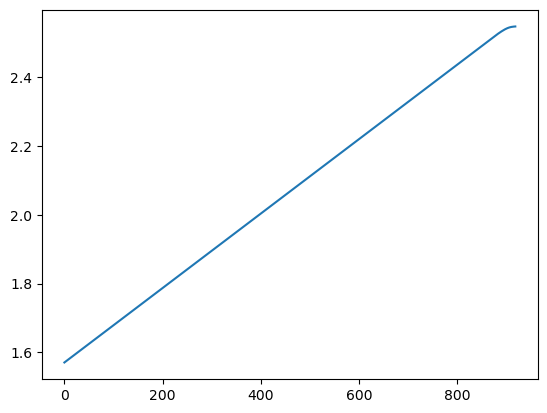

In [37]:
import matplotlib.pyplot as plt

plt.plot(simulation.y[2])
plt.show()

In [38]:
simulation.y.T

array([[ 6.77813600e+06,  0.00000000e+00,  1.57079633e+00,
         7.34126856e+03],
       [ 6.77813564e+06, -7.24813269e-01,  1.57187941e+00,
         7.34126816e+03],
       [ 6.77813455e+06, -1.44962924e+00,  1.57296249e+00,
         7.34126699e+03],
       ...,
       [ 6.38178464e+06, -1.23814135e+03,  2.54752718e+00,
         7.56262280e+02],
       [ 6.38054165e+06, -1.24785396e+03,  2.54763650e+00,
         6.41098423e+02],
       [ 6.37928892e+06, -1.25759219e+03,  2.54772896e+00,
         5.40913489e+02]])

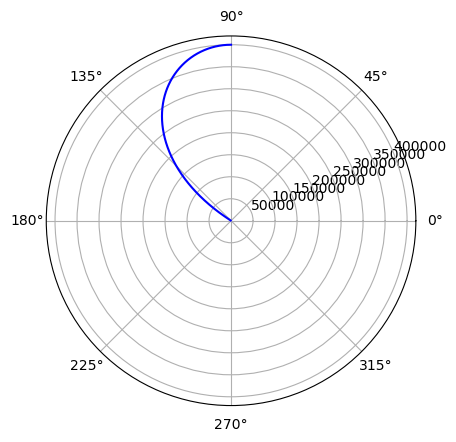

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

#n=np.argmin(np.abs(sol.y[0]-earth_radius))

R = simulation.y[0][:]-6378136.6
rad = simulation.y[2][:]
Phi = [np.pi/2 for i in rad]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R, c='b')

plt.show()

In [40]:
from copy import deepcopy

In [41]:
m = deepcopy(mean_0)

In [42]:
m = np.array([m[0], m[3]])

In [43]:
m

array([6.77826456e+06, 1.57079633e+00])

In [44]:
predicted_states_satellite_cord = [m]

In [45]:
radar_states_satellite_cord = [m]

In [48]:
for i in range(int(sim_lenght)):
    
    if i < sim_lenght:
        current_state_satellite_cord = tiagong.get_position_at_t(i)
        current_state_earth_cord = utilities.spherical_to_spherical(current_state_satellite_cord)
        noise_states_earth_cord = BACC.try_detect_satellite(current_state_earth_cord, i)
        #print(len(noise_states_earth_cord))

        print(len(noise_states_earth_cord))
        if len(noise_states_earth_cord) > 0:
            #print("Enter")
            flag = 0
            for state_earth_cord in noise_states_earth_cord:
                #print("Update0")
                state_satellite_cord = utilities.spherical_to_spherical(state_earth_cord.pos)
                new_state_satellite_cord = tianhe.update(state_satellite_cord[:2])

                if flag == 0:
                    radar_states_satellite_cord += state_satellite_cord[:2],
                    flag = 1
            
    forecast = tianhe.forecast()
    new_state_satellite_cord = [forecast[0][0][0], forecast[0][3][0]]

    predicted_states_satellite_cord += new_state_satellite_cord,

    #if earth.distance_to_surface(utilities.spherical_to_spherical(np.array([forecast[0][0][0], forecast[0][3][0], config['satellite']['initial_conditions']['azimuthal_angle']])))['inside']:
        #break




0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [17]:
R2, rad2 = np.array(predicted_states_satellite_cord[:]).T
R2 = R2 - 6378136.6
Phi = [np.pi/2 for i in rad]

In [20]:
print(R2)

[400127.96054152 400127.96054152 400127.96054152 400125.79162397
 400121.45378886 400114.94703619 400106.27136457 400000.97505627
 399987.23472762 399974.01233357 399961.30786214 399949.12129906
 399937.45263066 399940.21433173 399933.54922738 399927.81753764
 399923.01925419 399919.15436972 399916.22287792 399904.83552784
 399902.74850499 399901.54664021 399901.22993026 399901.79837287
 399903.25196672 399812.20629632 399807.11529441 399802.61303965
 399798.6995261  399795.37474843 399792.63870193 399644.04662813
 399632.23462798 399620.73249783 399609.5402255  399598.65779911
 399588.08520708 399542.08039468 399530.10045324 399518.38531985
 399506.93498229 399495.74942858 399484.82864702 399360.57776932
 399344.67122005 399328.92409186 399313.33636896 399297.90803571
 399282.63907659 399170.83932104 399151.80992406 399132.87201468
 399114.02557425 399095.27058427 399076.60702627 398982.55038592
 398961.27072625 398940.04117678 398918.86171686 398897.73232591
 398876.65298337 398738.5

In [18]:
radar_states_satellite_cord

R3, rad3 = np.array(radar_states_satellite_cord[1:]).T
R3 = R3 - 6378136.6

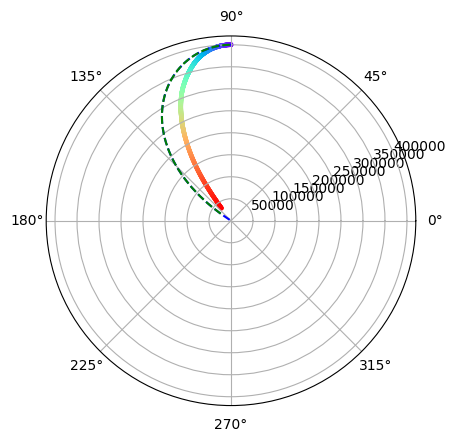

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

colors = plt.cm.rainbow(np.linspace(0, 1, len(R2)))

ax.plot(rad, R, c='b', linestyle="dashed")
ax.scatter(rad2, R2, c=colors, s=5)
ax.plot(rad3, R3, c='g', linestyle="dashed")

plt.show()

In [19]:

J = config['satellite']['initial_conditions']['azimuthal_angle']
NFK = []
for i in range(len(radar_states_satellite_cord))[1:]:
    NFK.append(np.array([radar_states_satellite_cord[i][0],radar_states_satellite_cord[i][1], J]))
x, z, y = utilities.earth_to_xyz_bulk(np.array(NFK).T)


R = simulation.y[0][:]
rad = simulation.y[2][:]
J = config['satellite']['initial_conditions']['azimuthal_angle']
NFK2 = []
for i in range(len(R)):
    NFK2.append(np.array([R[i],rad[i], J]))
x2, z2, y2 = utilities.earth_to_xyz_bulk(np.array(NFK2).T)


UnboundLocalError: cannot access local variable 'cartesian_state' where it is not associated with a value

In [ ]:
from RadarSystem import RadarSystem
import utilities
from Earth import Earth
from IPython.core.display_functions import clear_output
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, FloatSlider, Output, Button
import time

class Visualisation:
    def __init__(self, x_positions, y_positions, z_positions, x2, y2, z2, radar_positions=None, radars=None):
        self.x_positions = x_positions
        self.y_positions = y_positions
        self.z_positions = z_positions

        self.x_positions2 = x2
        self.y_positions2 = y2
        self.z_positions2 = z2

        self.radarSystem = radars


    re = Earth().re
    rp = Earth().rp
    show_range = 8000000

    def update_view(self, elev=30, azim=30):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlim([-self.show_range * 1.1, self.show_range * 1.1])
        ax.set_ylim([-self.show_range * 1.1, self.show_range * 1.1])
        ax.set_zlim([-self.show_range * 0.1, self.show_range * 0.1])
        ax.set_xlim([-self.show_range, self.show_range])
        ax.set_ylim([-self.show_range, self.show_range])
        ax.set_zlim([-self.show_range, self.show_range])

        # Earth surface
        u = np.linspace(0, 2 * np.pi, 200)
        v = np.linspace(0, np.pi, 200)
        x = self.re * np.outer(np.cos(u), np.sin(v))
        y = self.re * np.outer(np.sin(u), np.sin(v))
        z = self.rp * np.outer(np.ones(np.size(u)), np.cos(v))

        ax.plot_surface(x, y, z, color='b', rstride=4, cstride=4, alpha=0.5)
        ax.plot(self.x_positions, self.y_positions, self.z_positions, 'g')
        ax.plot(self.x_positions2, self.y_positions2, self.z_positions2,'b', linestyle='dashed')



        view_xs = []
        view_ys = []
        view_zs = []

        for i in range(len(self.x_positions)):
            pos = np.array([self.x_positions[i],self.y_positions[i],self.z_positions[i]])
            pos1 = utilities.c_to_p(pos)
            # print(pos)
            # print(pos1)
            # print("pos1")
            states = self.radarSystem.try_detect_satellite(pos1, i)
            #print(utilities.p_to_c(self.radarSystem.radars[0].position))
            if len(states) > 0:
                # print(states[0])
                c_pos = utilities.p_to_c(states[0].pos)
                view_xs.append(c_pos[0])
                view_ys.append(c_pos[1])
                view_zs.append(c_pos[2])

        ax.scatter(view_xs,view_ys,view_zs, color='r')
        # print("a")
        # print(view_xs)
        # print(view_ys)
        # print(view_zs)
        ax.view_init(elev=elev, azim=azim)
        # Plot radar positions
        for radar in self.radarSystem.radars:
            position = utilities.p_to_c(radar.position)
            ax.scatter(position[0], position[1], position[2], color='r', marker='o')
        ax.view_init(90,-90)
        plt.show()

orbit_radius = Earth().re + 2000000
theta = np.linspace(0, 2 * np.pi, 100)
orbit_x = orbit_radius * np.cos(theta)
orbit_y = orbit_radius * np.sin(theta)
orbit_z = np.zeros_like(orbit_x)
# Update the instantiation of the Visualisation class to include radar positions
visual = Visualisation(x, y, z, x2, y2, z2, radars=BACC)
visual.update_view()


NameError: name 'x' is not defined